In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from damped_newton import damped_newton, damped_newton_linesearch
from PMF import pmf_matrix_completion

In [21]:
input_folder = "img_align_celeba"
output_folder = "celeba_grayscale"  
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in sorted(os.listdir(input_folder))[:500]: #firt 500 image
    if filename.endswith(".jpg"):  #JPG format
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)
        grayscale_image = image.convert("L")
        grayscale_image = grayscale_image.resize((128, 128), Image.Resampling.LANCZOS)
        output_path = os.path.join(output_folder, filename)
        grayscale_image.save(output_path)

In [6]:
image_folder = "celeba_grayscale"  
image_size = (128, 128)  
#total 500 image
image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
num_images = 500
images = []

for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path)
    image_array = np.array(image) / 255.0 #normalize
    images.append(image_array)
images = np.array(images)

In [4]:
def mask_entries(image, sparsity_level=0.3,fill_value=0.0):
    mask = np.random.rand(*image.shape) < sparsity_level
    masked_image = image.copy()
    masked_image[mask] = fill_value
    return masked_image, mask

def calculate_mse(original, predicted, mask=True):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    return mse

def calculate_psnr(original, predicted, mask=True, max_pixel=1.0):
    error = original[mask] - predicted[mask]
    mse = np.mean(error ** 2)
    if mse == 0:
        return float('inf')  
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

#SGD

In [53]:
# SGD
image_SGD = images[2]
m, n = image_SGD.shape

masked_image_SGD, mask = mask_entries(image_SGD, sparsity_level=0.3)

k = 50  # Number of latent factors
U = np.random.normal(scale=1.0/k, size=(m, k))
V = np.random.normal(scale=1.0/k, size=(n, k))
learning_rate = 0.01
regularization = 0.1
num_epochs = 300

observed_pixels = np.array([(i, j) for i in range(m) for j in range(n) if not mask[i, j]])

for epoch in range(num_epochs):
    np.random.shuffle(observed_pixels)  # Shuffle observed pixels
    total_error = 0
    for i, j in observed_pixels:
        error = image_SGD[i, j] - np.dot(U[i, :], V[j, :].T) 
        U[i, :] += learning_rate * (error * V[j, :] - regularization * U[i, :])  
        V[j, :] += learning_rate * (error * U[i, :] - regularization * V[j, :])  
        total_error += error**2


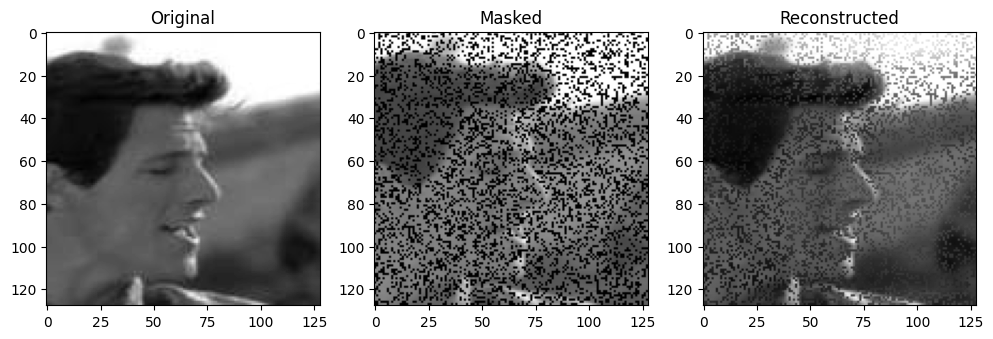

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_SGD, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_SGD, cmap='gray')
plt.title("Masked")

reconstructed_image_SGD = np.dot(U, V.T)
final_image = image_SGD.copy()
final_image[mask] = reconstructed_image_SGD[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_SGD = calculate_mse(image_SGD,final_image,True)
psnr_SGD=calculate_psnr(image_SGD,final_image,True,max_pixel=1.0)
print(mse_SGD)
print(psnr_SGD)

#PMF

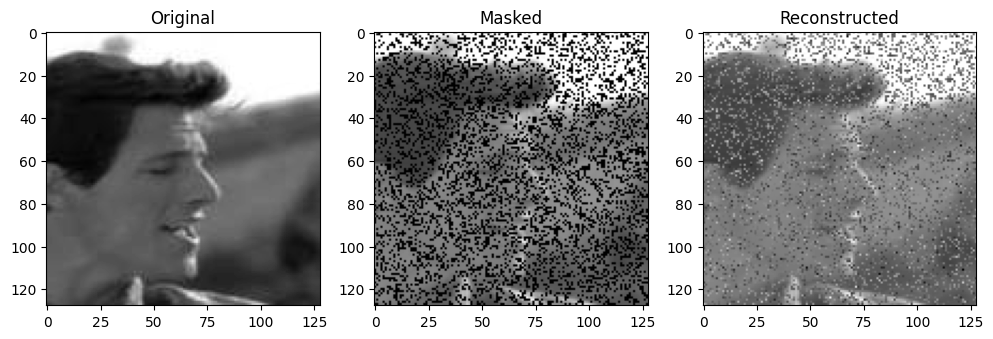

0.020050122571708053
16.978829680785253


In [26]:
image_PMF = images[2]
m, n = image_PMF.shape
masked_image_PMF, mask = mask_entries(image_PMF, sparsity_level=0.3)

U, V = pmf_matrix_completion(image_PMF, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_PMF, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_PMF, cmap='gray')
plt.title("Masked")

reconstructed_image_PMF = np.dot(U, V.T)
reconstructed_image_PMF -= reconstructed_image_PMF.min()
reconstructed_image_PMF /= reconstructed_image_PMF.max()

final_image_PMF = image_PMF.copy()
final_image_PMF[mask] = reconstructed_image_PMF[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_PMF, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_PMF = calculate_mse(image_PMF,final_image_PMF,True)
psnr_PMF=calculate_psnr(image_PMF,final_image_PMF,True,max_pixel=1.0)
print(mse_PMF)
print(psnr_PMF)

#Damped Newton

In [60]:
#Damped Newton
image_NT = images[2]
m, n = image_NT.shape  
masked_image_NT, mask = mask_entries(image_NT, sparsity_level=0.3)
W = (masked_image_NT != 0.0).astype(float)
A,B = damped_newton(masked_image_NT,W,10)

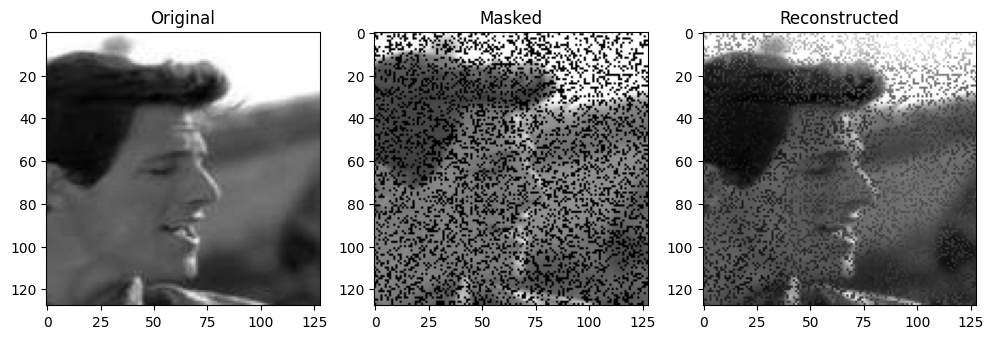

0.09594391734507748
10.179825534684213


In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NT, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NT, cmap='gray')
plt.title("Masked")

reconstructed_image_NT = np.dot(U, V.T)
final_image_NT = image_NT.copy()
final_image_NT[mask] = reconstructed_image_NT[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NT, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_NT = calculate_mse(image_NT,final_image_NT,True)
psnr_NT=calculate_psnr(image_NT,final_image_NT,True,max_pixel=1.0)
print(mse_NT)
print(psnr_NT)

#Damped Newton with linesearch

In [62]:
#Damped Newton with linesearch
image_NTls = images[2]
m, n = image_NTls.shape  
masked_image_NTls, mask = mask_entries(image_NTls, sparsity_level=0.3)
W = (masked_image_NTls != 0.0).astype(float)
A,B = damped_newton_linesearch(masked_image_NTls,W,10)

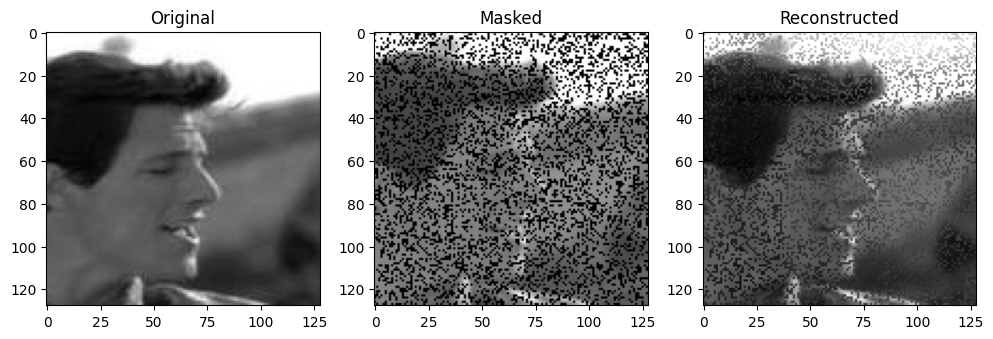

0.09890497802133172
10.047818492239744


In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_NTls, cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(masked_image_NTls, cmap='gray')
plt.title("Masked")

reconstructed_image_NTls = np.dot(U, V.T)
final_image_NTls = image_NTls.copy()
final_image_NTls[mask] = reconstructed_image_NTls[mask]
plt.subplot(1, 3, 3)
plt.imshow(final_image_NTls, cmap='gray')
plt.title("Reconstructed")
plt.show()
mse_NTls = calculate_mse(masked_image_NTls,final_image,True)
psnr_NTls=calculate_psnr(masked_image_NTls,final_image,True,max_pixel=1.0)
print(mse_NTls)
print(psnr_NTls)